# Pull Request Analysis

In [3]:
import psycopg2
import pandas as pd 
# from sqlalchemy.types import Integer, Text, String, DateTime
import sqlalchemy as salc
import matplotlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json


with open("config.json") as config_file:
    config = json.load(config_file)

database_connection_string = 'postgres+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

dbschema='augur_data'
engine = salc.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

## Pull Request Filter

In [4]:
## List of repository IDs for the report
repo_set = {25760, 25663}

# Identifying the Longest Running Pull Requests

## Getting the Data

In [5]:
pr_all = pd.DataFrame()

for repo_id in repo_set: 

    pr_query = salc.sql.text(f"""
                    SELECT
                        repo.repo_id AS repo_id,
                        pull_requests.pr_src_id AS pr_src_id,
                        repo.repo_name AS repo_name,
                        pr_src_author_association,
--                         repo_groups.rg_name AS repo_group,
                        pull_requests.pr_src_state,
                        pull_requests.pr_merged_at,
                        pull_requests.pr_created_at AS pr_created_at,
                        pull_requests.pr_closed_at AS pr_closed_at,
                        date_part( 'year', pr_created_at :: DATE ) AS CREATED_YEAR,
                        date_part( 'month', pr_created_at :: DATE ) AS CREATED_MONTH,
						   date_part( 'year', pr_closed_at :: DATE ) AS CLOSED_YEAR,
                        date_part( 'month', pr_closed_at :: DATE ) AS CLOSED_MONTH,
                        ( EXTRACT ( EPOCH FROM pull_requests.pr_closed_at ) - EXTRACT ( EPOCH FROM pull_requests.pr_created_at ) ) / 3600 AS hours_to_close,
                        ( EXTRACT ( EPOCH FROM pull_requests.pr_closed_at ) - EXTRACT ( EPOCH FROM pull_requests.pr_created_at ) ) / 86400 AS days_to_close, 
                        ( EXTRACT ( EPOCH FROM first_response_time ) - EXTRACT ( EPOCH FROM pull_requests.pr_created_at ) ) / 3600 AS hours_to_first_response,
                        ( EXTRACT ( EPOCH FROM first_response_time ) - EXTRACT ( EPOCH FROM pull_requests.pr_created_at ) ) / 86400 AS days_to_first_response, 
                        ( EXTRACT ( EPOCH FROM last_response_time ) - EXTRACT ( EPOCH FROM pull_requests.pr_created_at ) ) / 3600 AS hours_to_last_response,
                        ( EXTRACT ( EPOCH FROM last_response_time ) - EXTRACT ( EPOCH FROM pull_requests.pr_created_at ) ) / 86400 AS days_to_last_response, 
--                         pull_requests.pr_html_url AS pr_url, pull_requests.pr_src_title AS pr_title,
                        first_response_time,
                        last_response_time,
                        average_time_between_responses,
                        assigned_count,
                        review_requested_count,
                        labeled_count,
                        subscribed_count,
                        mentioned_count,
                        referenced_count,
                        closed_count,
                        head_ref_force_pushed_count,
                        merged_count,
                        milestoned_count,
                        unlabeled_count,
                        head_ref_deleted_count,
                        comment_count--,
                       -- lines_of_code_added, 
                       -- commit_count, 
                       -- file_count
                    FROM
                        repo,
                        repo_groups,
                        pull_requests,
                        ( 
                            SELECT pull_requests.pull_request_id,
                            count(*) FILTER (WHERE action = 'assigned') AS assigned_count,
                            count(*) FILTER (WHERE action = 'review_requested') AS review_requested_count,
                            count(*) FILTER (WHERE action = 'labeled') AS labeled_count,
                            count(*) FILTER (WHERE action = 'unlabeled') AS unlabeled_count,
                            count(*) FILTER (WHERE action = 'subscribed') AS subscribed_count,
                            count(*) FILTER (WHERE action = 'mentioned') AS mentioned_count,
                            count(*) FILTER (WHERE action = 'referenced') AS referenced_count,
                            count(*) FILTER (WHERE action = 'closed') AS closed_count,
                            count(*) FILTER (WHERE action = 'head_ref_force_pushed') AS head_ref_force_pushed_count,
                            count(*) FILTER (WHERE action = 'head_ref_deleted') AS head_ref_deleted_count,
                            count(*) FILTER (WHERE action = 'milestoned') AS milestoned_count,
                            count(*) FILTER (WHERE action = 'merged') AS merged_count,
                            MIN(message.msg_timestamp) AS first_response_time,
                            COUNT(DISTINCT message.msg_timestamp) AS comment_count,
                            MAX(message.msg_timestamp) AS last_response_time,
                            (MAX(message.msg_timestamp) - MIN(message.msg_timestamp)) / COUNT(DISTINCT message.msg_timestamp) AS average_time_between_responses

                            FROM pull_request_events, pull_requests, repo, pull_request_message_ref, message
                            WHERE repo.repo_id = {repo_id}
                            AND repo.repo_id = pull_requests.repo_id
                            AND pull_requests.pull_request_id = pull_request_events.pull_request_id
                            AND pull_requests.pull_request_id = pull_request_message_ref.pull_request_id
                            AND pull_request_message_ref.msg_id = message.msg_id

                            GROUP BY pull_requests.pull_request_id
                        ) response_times--,
                        /*(
                            SELECT sum(cmt_added) AS lines_of_code_added, pull_request_id, count(DISTINCT cmt_commit_hash) AS commit_count, count(DISTINCT cmt_filename) AS file_count
                            FROM (
                                SELECT pr_cmt_id, cmt_added, pull_request_commits.pull_request_id, cmt_commit_hash, cmt_filename
                                FROM pull_request_commits, commits, pull_requests, pull_request_meta
                                WHERE cmt_commit_hash = pr_cmt_sha
                                AND pull_requests.pull_request_id = pull_request_commits.pull_request_id
                                AND pull_requests.pull_request_id = pull_request_meta.pull_request_id
                                AND pull_request_meta.pr_head_or_base = 'base' AND pr_src_meta_label LIKE '%master'
                                AND pull_requests.repo_id = {repo_id}
                                AND commits.repo_id = pull_requests.repo_id
                                AND commits.cmt_commit_hash <> pull_requests.pr_merge_commit_sha
                            ) AS pr_cmt_info
                            GROUP BY pull_request_id
                        ) counts*/
                    WHERE repo.repo_group_id = repo_groups.repo_group_id 
                        AND repo.repo_id = pull_requests.repo_id 
                        AND repo.repo_id = {repo_id} 
                        AND response_times.pull_request_id = pull_requests.pull_request_id
                       -- AND counts.pull_request_id = pull_requests.pull_request_id
                    ORDER BY
                       merged_count DESC

        """)
    pr_a = pd.read_sql(pr_query, con=engine)
    if not pr_all.empty: 
        pr_all = pd.concat([pr_all, pr_a]) 
    else: 
        # first repo
        pr_all = pr_a
display(pr_all.head())

,repo_id,pr_src_id,repo_name,pr_src_author_association,pr_src_state,pr_merged_at,pr_created_at,pr_closed_at,created_year,created_month,...,subscribed_count,mentioned_count,referenced_count,closed_count,head_ref_force_pushed_count,merged_count,milestoned_count,unlabeled_count,head_ref_deleted_count,comment_count
0,25760,24951633,spring-boot,CONTRIBUTOR,closed,2015-01-05 19:57:45,2014-11-24 18:09:25,2015-01-05 19:57:45,2014.0,11.0,...,0,0,0,9,0,9,0,9,0,9
1,25760,16021779,spring-boot,MEMBER,closed,2014-05-18 13:33:55,2014-05-17 16:34:24,2014-05-18 13:33:55,2014.0,5.0,...,0,0,0,6,0,6,6,0,0,6
2,25760,14661155,spring-boot,CONTRIBUTOR,closed,2014-04-16 11:22:05,2014-04-11 16:03:44,2014-04-16 11:22:05,2014.0,4.0,...,0,0,0,5,0,5,5,0,0,5
3,25760,150945798,spring-boot,NONE,closed,2017-11-10 13:46:03,2017-11-06 20:02:46,2017-11-10 13:46:03,2017.0,11.0,...,8,8,8,4,0,4,4,8,4,4
4,25760,17696973,spring-boot,CONTRIBUTOR,closed,2014-06-27 11:11:07,2014-06-27 10:59:20,2014-06-27 11:11:07,2014.0,6.0,...,0,0,4,4,0,4,4,0,0,4


# Begin data pre-processing and adding columns

In [7]:
pr_all[['assigned_count',
          'review_requested_count',
          'labeled_count',
          'subscribed_count',
          'mentioned_count',
          'referenced_count',
          'closed_count',
          'head_ref_force_pushed_count',
          'merged_count',
          'milestoned_count',
          'unlabeled_count',
          'head_ref_deleted_count',
          'comment_count',
           'created_year',
           'closed_year'
       ]] = pr_all[['assigned_count',
                                      'review_requested_count',
                                      'labeled_count',
                                      'subscribed_count',
                                      'mentioned_count',
                                      'referenced_count',
                                      'closed_count',
                                        'head_ref_force_pushed_count',
                                    'merged_count',
                                      'milestoned_count',          
                                      'unlabeled_count',
                                      'head_ref_deleted_count',
                                      'comment_count',
                                        'created_year',
                                        'closed_year'
                   ]].fillna(-1).astype(int)


In [8]:
print(pr_all['repo_name'].unique())

['spring-boot' 'spring-framework']


In [9]:
# Get days for average_time_between_responses time delta

pr_all['average_days_between_responses'] = pr_all['average_time_between_responses'].map(lambda x: x.days).astype(float)
pr_all['average_hours_between_responses'] = pr_all['average_time_between_responses'].map(lambda x: x.days * 24).astype(float)



In [10]:
# Disabled end_date filtering for now to include PRs that are still open

start_date = pd.to_datetime('2017-07-01 01:00:00')
# end_date = pd.to_datetime('2020-02-01 09:00:00')
end_date = pd.to_datetime('2019-12-31 23:59:59')
pr_all = pr_all[(pr_all['pr_created_at'] > start_date) & (pr_all['pr_closed_at'] < end_date)]

pr_all['created_year'] = pr_all['created_year'].map(int)
pr_all['created_month'] = pr_all['created_month'].map(int)
pr_all['created_month'] = pr_all['created_month'].map(lambda x: '{0:0>2}'.format(x))
pr_all['created_yearmonth'] = pd.to_datetime(pr_all['created_year'].map(str) + '-' + pr_all['created_month'].map(str) + '-01')
pr_all.head(1)

,repo_id,pr_src_id,repo_name,pr_src_author_association,pr_src_state,pr_merged_at,pr_created_at,pr_closed_at,created_year,created_month,...,closed_count,head_ref_force_pushed_count,merged_count,milestoned_count,unlabeled_count,head_ref_deleted_count,comment_count,average_days_between_responses,average_hours_between_responses,created_yearmonth
3,25760,150945798,spring-boot,NONE,closed,2017-11-10 13:46:03,2017-11-06 20:02:46,2017-11-10 13:46:03,2017,11,...,4,0,4,4,8,4,4,0.0,0.0,2017-11-01


In [11]:
import datetime
# getting the number of days of (today - created at) for the PRs that are still open
# and putting this in the days_to_close column

days_to_close_open_pr = datetime.datetime.now() - pr_all.loc[pr_all['pr_src_state'] == 'open']['pr_created_at']
days_to_close_open_pr = days_to_close_open_pr.apply(lambda x: x.days).astype(int)
pr_all.loc[pr_all['pr_src_state'] == 'open'] = pr_all.loc[pr_all['pr_src_state'] == 'open'].assign(days_to_close=days_to_close_open_pr)

pr_all['closed_yearmonth'] = pd.to_datetime(np.nan)

# Extra operations/fields for closed pr df
pr_all.loc[pr_all['pr_src_state'] == 'closed'] = pr_all.loc[pr_all['pr_src_state'] == 'closed'].assign(closed_yearmonth=pd.to_datetime(pr_all.loc[pr_all['pr_src_state'] == 'closed']['closed_year'].astype(int).map(str) + '-' + pr_all.loc[pr_all['pr_src_state'] == 'closed']['closed_month'].astype(int).map(str) + '-01'))

# pr_all.dtypes
pr_all.loc[pr_all['pr_src_state'] == 'closed']

,repo_id,pr_src_id,repo_name,pr_src_author_association,pr_src_state,pr_merged_at,pr_created_at,pr_closed_at,created_year,created_month,...,head_ref_force_pushed_count,merged_count,milestoned_count,unlabeled_count,head_ref_deleted_count,comment_count,average_days_between_responses,average_hours_between_responses,created_yearmonth,closed_yearmonth
3,25760,150945798,spring-boot,NONE,closed,2017-11-10 13:46:03,2017-11-06 20:02:46,2017-11-10 13:46:03,2017,11,...,0,4,4,8,4,4,0.0,0.0,2017-11-01,2017-11-01
7,25760,140666948,spring-boot,CONTRIBUTOR,closed,2017-09-14 17:06:11,2017-09-12 19:45:52,2017-09-14 17:06:11,2017,09,...,0,3,3,3,3,3,0.0,0.0,2017-09-01,2017-09-01
11,25760,144556511,spring-boot,CONTRIBUTOR,closed,2017-10-06 07:12:29,2017-10-04 00:00:14,2017-10-06 07:12:29,2017,10,...,2,2,2,2,0,2,0.0,0.0,2017-10-01,2017-10-01
13,25760,154166320,spring-boot,CONTRIBUTOR,closed,2017-11-22 14:27:59,2017-11-22 14:22:47,2017-11-22 14:27:59,2017,11,...,0,1,0,1,1,1,0.0,0.0,2017-11-01,2017-11-01
17,25760,273692620,spring-boot,CONTRIBUTOR,closed,2019-04-25 23:40:05,2019-04-25 21:40:30,2019-04-25 23:40:05,2019,04,...,0,1,1,1,0,1,0.0,0.0,2019-04-01,2019-04-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1800,25663,353874834,spring-framework,NONE,closed,NaT,2019-12-17 01:57:11,2019-12-20 11:23:32,2019,12,...,0,0,0,3,0,3,1.0,24.0,2019-12-01,2019-12-01
1802,25663,354444283,spring-framework,NONE,closed,NaT,2019-12-18 06:17:55,2019-12-19 12:56:19,2019,12,...,0,0,2,4,0,2,0.0,0.0,2019-12-01,2019-12-01
1803,25663,355578600,spring-framework,CONTRIBUTOR,closed,NaT,2019-12-20 07:17:24,2019-12-20 11:25:29,2019,12,...,0,0,1,1,1,1,0.0,0.0,2019-12-01,2019-12-01
1805,25663,355968353,spring-framework,NONE,closed,NaT,2019-12-21 04:16:39,2019-12-21 11:44:29,2019,12,...,0,0,0,2,0,2,0.0,0.0,2019-12-01,2019-12-01


In [12]:
""" Merged flag """
if 'pr_merged_at' in pr_all.columns.values:
    pr_all['pr_merged_at'] = pr_all['pr_merged_at'].fillna(0)
    pr_all['merged_flag'] = 'Not Merged / Rejected'
    pr_all['merged_flag'].loc[pr_all['pr_merged_at'] != 0] = 'Merged / Accepted'
    pr_all['merged_flag'].loc[pr_all['pr_src_state'] == 'open'] = 'Still Open'
    del pr_all['pr_merged_at']
pr_all['merged_flag']

/Volumes/SeansRAIDBaby/github/virtualenvs/augur-vizplay/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


3           Merged / Accepted
7           Merged / Accepted
11          Merged / Accepted
13          Merged / Accepted
17          Merged / Accepted
                ...          
1800    Not Merged / Rejected
1802    Not Merged / Rejected
1803    Not Merged / Rejected
1805    Not Merged / Rejected
1806    Not Merged / Rejected
Name: merged_flag, Length: 2418, dtype: object

# Split into different dataframes
### All, open, closed, and slowest 20% of these 3 categories (6 dataframes total)

In [13]:
# Isolate the different state PRs for now
pr_open = pr_all.loc[pr_all['pr_src_state'] == 'open']
pr_closed = pr_all.loc[pr_all['pr_src_state'] == 'closed']
pr_merged = pr_all.loc[pr_all['merged_flag'] == 'Merged / Accepted']
pr_not_merged = pr_all.loc[pr_all['merged_flag'] == 'Not Merged / Rejected']
pr_closed['merged_flag']

3           Merged / Accepted
7           Merged / Accepted
11          Merged / Accepted
13          Merged / Accepted
17          Merged / Accepted
                ...          
1800    Not Merged / Rejected
1802    Not Merged / Rejected
1803    Not Merged / Rejected
1805    Not Merged / Rejected
1806    Not Merged / Rejected
Name: merged_flag, Length: 2418, dtype: object

In [14]:
# Filtering the 80th percentile slowest PRs
import warnings
warnings.filterwarnings('ignore')

def filter_20_per_slowest(input_df):
    pr_slow20_filtered = pd.DataFrame()
    pr_slow20_x = pd.DataFrame()
    for value in repo_set: 
        if not pr_slow20_filtered.empty: 
            pr_slow20x = input_df.query('repo_id==@value')
            pr_slow20x['percentile_rank_local'] = pr_slow20x.days_to_close.rank(pct=True)
            pr_slow20x = pr_slow20x.query('percentile_rank_local >= .8', )
            pr_slow20_filtered = pd.concat([pr_slow20x, pr_slow20_filtered]) 
            reponame = str(value)
            filename = ''.join(['output/pr_slowest20pct', reponame, '.csv'])
            pr_slow20x.to_csv(filename)
        else: 
            # first time
            pr_slow20_filtered = input_df.copy()
            pr_slow20_filtered['percentile_rank_local'] = pr_slow20_filtered.days_to_close.rank(pct=True)
            pr_slow20_filtered = pr_slow20_filtered.query('percentile_rank_local >= .8', )
#     print(pr_slow20_filtered.describe())
    return pr_slow20_filtered

pr_slow20_open = filter_20_per_slowest(pr_open)
pr_slow20_closed = filter_20_per_slowest(pr_closed)
pr_slow20_merged = filter_20_per_slowest(pr_merged)
pr_slow20_not_merged = filter_20_per_slowest(pr_not_merged)
pr_slow20_all = filter_20_per_slowest(pr_all)
pr_slow20_merged#.head()

,repo_id,pr_src_id,repo_name,pr_src_author_association,pr_src_state,pr_created_at,pr_closed_at,created_year,created_month,closed_year,...,milestoned_count,unlabeled_count,head_ref_deleted_count,comment_count,average_days_between_responses,average_hours_between_responses,created_yearmonth,closed_yearmonth,merged_flag,percentile_rank_local
0,25663,240771476,spring-framework,CONTRIBUTOR,closed,2018-12-24 12:55:05,2019-02-27 14:15:45,2018,12,2019,...,29,58,0,29,2.0,48.0,2018-12-01,2019-02-01,Merged / Accepted,0.988235
1,25663,263835589,spring-framework,MEMBER,closed,2019-03-23 14:15:12,2019-05-02 09:59:11,2019,03,2019,...,32,16,16,16,2.0,48.0,2019-03-01,2019-05-01,Merged / Accepted,0.970588
12,25663,253635905,spring-framework,CONTRIBUTOR,closed,2019-02-16 10:59:57,2019-05-07 10:44:05,2019,02,2019,...,12,6,0,6,13.0,312.0,2019-02-01,2019-05-01,Merged / Accepted,0.994118
18,25663,244762643,spring-framework,CONTRIBUTOR,closed,2019-01-15 11:34:39,2019-02-05 14:39:47,2019,01,2019,...,5,0,0,5,4.0,96.0,2019-01-01,2019-02-01,Merged / Accepted,0.952941
33,25663,328534647,spring-framework,NONE,closed,2019-10-16 01:58:54,2019-11-13 16:48:27,2019,10,2019,...,4,4,0,4,5.0,120.0,2019-10-01,2019-11-01,Merged / Accepted,0.958824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,25663,313198427,spring-framework,MEMBER,closed,2019-09-02 10:01:43,2019-09-20 18:48:40,2019,09,2019,...,1,1,1,1,0.0,0.0,2019-09-01,2019-09-01,Merged / Accepted,0.943820
252,25663,311054905,spring-framework,MEMBER,closed,2019-08-26 19:29:11,2019-09-02 16:37:55,2019,08,2019,...,1,2,0,1,0.0,0.0,2019-08-01,2019-09-01,Merged / Accepted,0.870787
254,25663,245838019,spring-framework,CONTRIBUTOR,closed,2019-01-18 13:01:40,2019-02-04 22:22:21,2019,01,2019,...,2,2,1,1,0.0,0.0,2019-01-01,2019-02-01,Merged / Accepted,0.938202
272,25663,308027047,spring-framework,CONTRIBUTOR,closed,2019-08-16 10:38:29,2019-08-27 16:22:45,2019,08,2019,...,1,1,1,1,0.0,0.0,2019-08-01,2019-08-01,Merged / Accepted,0.910112


# Start Visualization Methods

In [16]:
from bokeh.palettes import Colorblind, mpl, magma, Accent, GnBu3, OrRd3, Category20, inferno, Plasma256, Turbo256
import bokeh
from bokeh.layouts import gridplot
from bokeh.models.annotations import Title
from bokeh.io import export_png
from bokeh.io import show, output_notebook
from bokeh.models import ColumnDataSource, Legend, LabelSet
from bokeh.plotting import figure
from bokeh.sampledata.sprint import sprint
from bokeh.models.glyphs import Rect
from bokeh.transform import dodge

# colors = Colorblind[len(repo_set)]
#mpl['Plasma'][len(repo_set)]
#['A6CEE3','B2DF8A','33A02C','FB9A99']

def remove_outliers(input_df, field, num_outliers_repo_map):
    df_no_outliers = input_df.copy()
    for repo_name, num_outliers in num_outliers_repo_map.items():
        indices_to_drop = input_df.loc[input_df['repo_name'] == repo_name].nlargest(num_outliers, field).index
        df_no_outliers = df_no_outliers.drop(index=indices_to_drop)
    return df_no_outliers
            

In [21]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import datetime as dt

def visualize_mean_days_to_close(input_df, x_axis='closed_yearmonth', description='Closed', num_remove_outliers=0, drop_outliers_repo=None):

    # Set the df you want to build the viz's for
    driver_df = input_df.copy()
    
    driver_df = driver_df[['repo_id', 'repo_name', 'pr_src_id', 'created_yearmonth', 'closed_yearmonth', 'days_to_close']]

#    if save_files:
#        driver_df.to_csv('output/c.pr_slow20small {}.csv'.format(description))
    
    driver_df_mean = driver_df.groupby(['repo_id', x_axis, 'repo_name'],as_index=False).mean()
        
    # Total PRS Closed
    fig, ax = plt.subplots()
    # the size of A4 paper
    fig.set_size_inches(24, 8)
    plotter = sns.lineplot(x=x_axis, y='days_to_close', style='repo_name', data=driver_df_mean, sort=True, legend='full', linewidth=2.5, hue='repo_name').set_title("Average Days to Close of {} Pull Requests, July 2017-January 2020".format(description))  
#    if save_files:
#        fig.savefig('images/slow_20_mean {}.png'.format(description))
    
    # Copying array and deleting the outlier in the copy to re-visualize
    def drop_n_largest(input_df, n, repo_name):
        input_df_copy = input_df.copy()
        indices_to_drop = input_df.loc[input_df['repo_name'] == 'amazon-freertos'].nlargest(n,'days_to_close').index
        print("Indices to drop: {}".format(indices_to_drop))
        input_df_copy = input_df_copy.drop(index=indices_to_drop)
        input_df_copy.loc[input_df['repo_name'] == repo_name]
        return input_df_copy

    if num_remove_outliers > 0 and drop_outliers_repo:
        driver_df_mean_no_outliers = drop_n_largest(driver_df_mean, num_remove_outliers, drop_outliers_repo)
    
        # Total PRS Closed without outlier
        fig, ax = plt.subplots()
        # the size of A4 paper
        fig.set_size_inches(24, 8)
        plotter = sns.lineplot(x=x_axis, y='days_to_close', style='repo_name', data=driver_df_mean_no_outliers, sort=False, legend='full', linewidth=2.5, hue='repo_name').set_title("Average Days to Close among {} Pull Requests Without Outlier, July 2017-January 2020".format(description))
        plotterlabels = ax.set_xticklabels(driver_df_mean_no_outliers[x_axis], rotation=90, fontsize=8)
#        if save_files:
#            fig.savefig('images/slow_20_mean_no_outlier {}.png'.format(description))
    

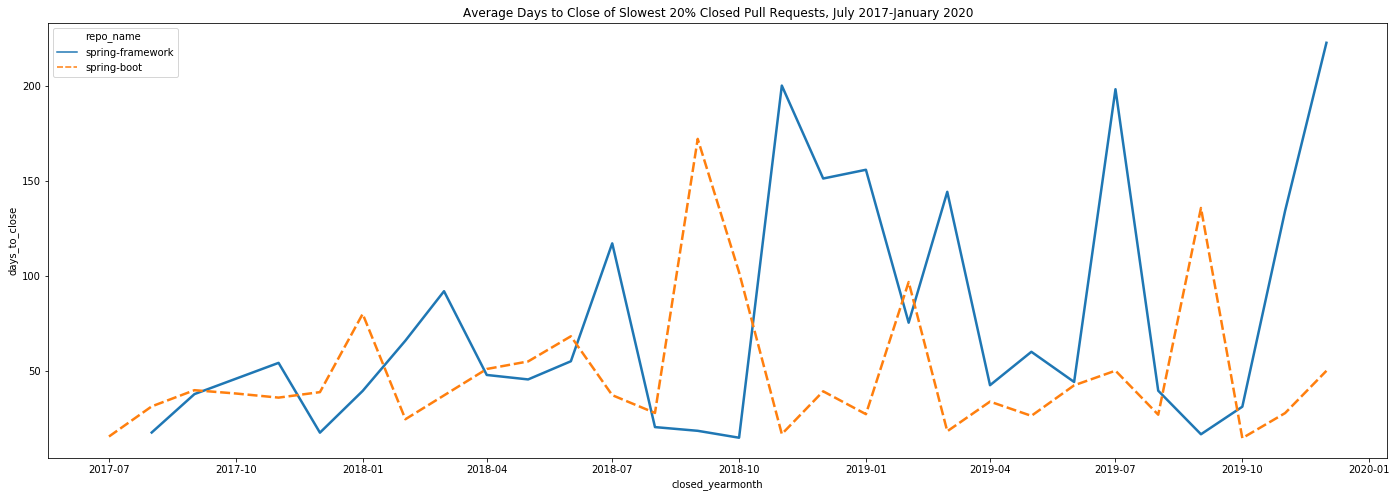

In [22]:
visualize_mean_days_to_close(pr_slow20_closed, description='Slowest 20% Closed')

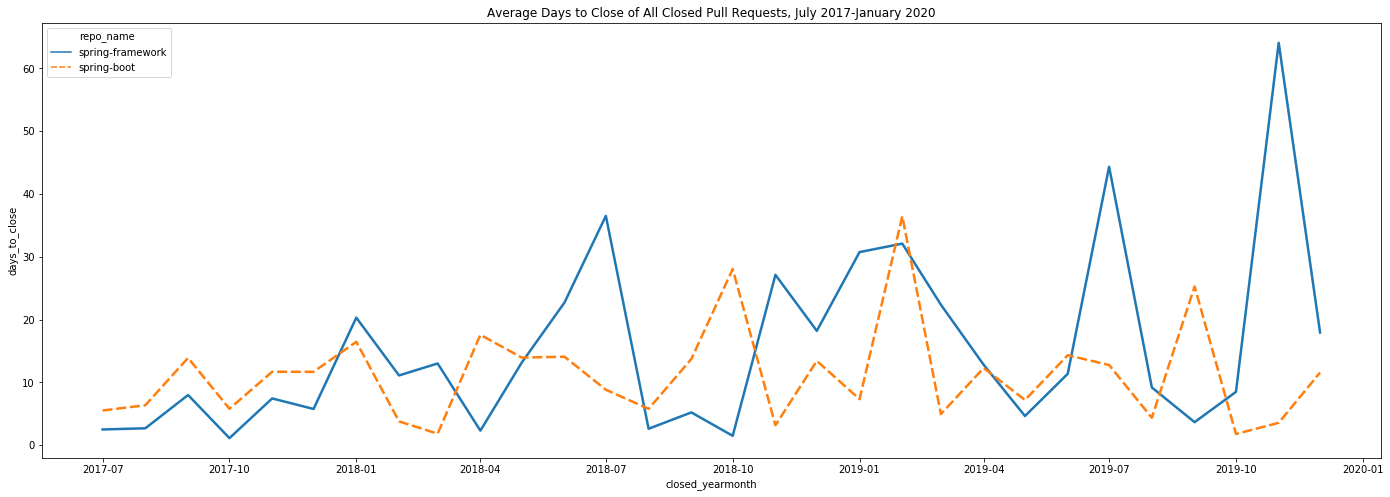

In [23]:
visualize_mean_days_to_close(pr_closed, description='All Closed')

In [24]:
def horizontal_stacked_bar(input_df, group_by='merged_flag', x_axis='comment_count', facet="created_year", repo_name=None, x_max=1000, columns=2, description="", y_axis='repo_name', same_scales=True, title="Average Pull Request Comments by Merged Status", save_file=False):
    driver_df = input_df.copy()
    
    if repo_name:
        driver_df = driver_df.loc[driver_df['repo_name'] == repo_name]
        
#     driver_df = driver_df[['repo_id', y_axis, group_by, x_axis, facet]]
    if facet == 'closed_year' or y_axis == 'closed_year':
        driver_df['closed_year'] = driver_df['closed_year'].astype(int).astype(str)

    output_notebook()
    
    try:
        y_groups = sorted(list(driver_df[y_axis].unique()))
    except:
        y_groups = [repo_name]
    try:
        facet_groups = sorted(driver_df[facet].unique())
    except:
        facet_groups = [repo_name]
        
    groups = driver_df[group_by].unique()
    try:
        colors = mpl['Plasma'][len(groups)]
    except:
        colors = [mpl['Plasma'][3][0]] + [mpl['Plasma'][3][1]]
        
    len_not_merged = len(driver_df.loc[driver_df['merged_flag'] == 'Not Merged / Rejected'])
    len_merged = len(driver_df.loc[driver_df['merged_flag'] == 'Merged / Accepted'])
    print(len_merged, len_not_merged)
    if repo_name == 'mbed-os':
        colors = colors[::-1]
    print(colors)
    
    grid_array = []
    grid_row = []    
    
    for index, facet_group in enumerate(facet_groups):
        facet_data = driver_df.loc[driver_df[facet] == facet_group]

        title_ending = 'Created in {}'.format(facet_group) if facet == 'created_year' else 'Closed in {}'.format(facet_group) if facet == 'closed_year' else 'for Repo: {}'.format(facet_group) if repo_name else facet_group
        p = figure(y_range=y_groups, plot_height=450, plot_width=650, x_range=(0,x_max), # y_range=y_groups,#(pr_all[y_axis].min(),pr_all[y_axis].max()) #y_axis_type="datetime",
                   title='{} {}'.format(title.format(description), title_ending))
        
        for y_value in facet_data[y_axis].unique():
            
            y_merged_data = facet_data.loc[(facet_data[y_axis] == y_value) & (facet_data['merged_flag'] == 'Merged / Accepted')]
            y_not_merged_data = facet_data.loc[(facet_data[y_axis] == y_value) & (facet_data['merged_flag'] == 'Not Merged / Rejected')]
            
            if len(y_merged_data) > 0:
                y_merged_data[x_axis + '_mean'] = y_merged_data[x_axis].mean().round(1)
            else:
                y_merged_data[x_axis + '_mean'] = 0.00
            
            if len(y_not_merged_data) > 0:
                y_not_merged_data[x_axis + '_mean'] = y_not_merged_data[x_axis].mean().round(1)
            else:
                y_not_merged_data[x_axis + '_mean'] = 0

            not_merged_source = ColumnDataSource(y_not_merged_data)
            merged_source = ColumnDataSource(y_merged_data)
        
            # mean comment count for merged
            merged_comment_count_glyph = p.hbar(y=dodge(y_axis, -0.1, range=p.y_range), left=0, right=x_axis + '_mean', height=0.04*len(facet_data[y_axis].unique()), 
                                         source=merged_source, fill_color="black")#,legend_label="Mean Days to Close",
            # Data label 
            labels = LabelSet(x=x_axis + '_mean', y=dodge(y_axis, -0.1, range=p.y_range), text=x_axis + '_mean', y_offset=-8, x_offset=34,
                      text_font_size="12pt", text_color="black",
                      source=merged_source, text_align='center')
            p.add_layout(labels)
            # mean comment count For nonmerged
            not_merged_comment_count_glyph = p.hbar(y=dodge(y_axis, 0.1, range=p.y_range), left=0, right=x_axis + '_mean', 
                                         height=0.04*len(facet_data[y_axis].unique()), source=not_merged_source, fill_color="#e84d60")#legend_label="Mean Days to Close",
            # Data label 
            labels = LabelSet(x=x_axis + '_mean', y=dodge(y_axis, 0.1, range=p.y_range), text=x_axis + '_mean', y_offset=-8, x_offset=34,
                      text_font_size="12pt", text_color="#e84d60",
                      source=not_merged_source, text_align='center')
            p.add_layout(labels)
        
#         p.y_range.range_padding = 0.1
        p.ygrid.grid_line_color = None
        p.legend.location = "bottom_right"
        p.axis.minor_tick_line_color = None
        p.outline_line_color = None
        p.xaxis.axis_label = 'Average Comments / Pull Request'
        p.yaxis.axis_label = 'Repository' if y_axis == 'repo_name' else 'Year Closed' if y_axis == 'closed_year' else ''
        
        legend = Legend(
                items=[
                    ("Merged Pull Request Mean Comment Count", [merged_comment_count_glyph]),
                    ("Rejected Pull Request Mean Comment Count", [not_merged_comment_count_glyph])
                ],
                
                location='center', 
                orientation='vertical',
                border_line_color="black"
            )
        p.add_layout(legend, "below")
        
        grid_row.append(p)
        if index % columns == columns - 1:
            grid_array.append(grid_row)
            grid_row = []
            
    grid = gridplot(grid_array)
    show(grid, plot_width=1200, plot_height=1200)
    
    if save_file:
        repo_extension = 'All' if not repo_name else repo_name
        export_png(grid, filename="./images/h_stacked_bar_mean_comments_merged_status/mean_comments_merged_status__facet_{}__{}_PRs__yaxis_{}__repo_{}.png".format(facet, description, y_axis, repo_extension))


In [25]:
horizontal_stacked_bar(pr_slow20_closed, description="Slowest 20% Closed", group_by='merged_flag', save_file=False, facet="repo_name", columns=1,repo_name='zephyr', x_max=12, same_scales=True, x_axis='comment_count', y_axis='closed_year', title="Mean Comments for {} Pull Requests")

# for repo_name in pr_all['repo_name'].unique():
horizontal_stacked_bar(pr_slow20_closed, description="Slowest 20% Closed", group_by='merged_flag', save_file=False, facet="repo_name", columns=1, x_max=12, same_scales=True, x_axis='comment_count', y_axis='repo_name', title="Mean Comments for {} Pull Requests")


Loading BokehJS ...

0 0
['#0C0786', '#CA4678']


Loading BokehJS ...

37 614
['#0C0786', '#CA4678']


In [26]:
def merged_ratio_vertical_stacked_bar(data_dict, facet='closed_year', repo_name=None,x_axis='repo_name', save_file=False, y_max=5000, same_scales=True, columns=2, description="All", title="{}"):
    
        
    output_notebook()
    
    colors = mpl['Plasma'][6]
        
    if repo_name == 'mbed-os':
        colors = colors[::-1]
    print(colors)
        
    grid_array = []
    grid_row = []    
    
    for data_desc, input_df in data_dict.items():
        x_groups = sorted(list(input_df[x_axis].astype(str).unique()))
        break
    
    title_ending = 'Created in {}'.format(facet_group) if facet == 'created_year' else 'Closed in {}'.format(facet_group) if facet == 'closed_year' else 'for Repo: {}'.format(repo_name) if repo_name else facet_group
    p = figure(x_range=x_groups, y_range=(0, y_max), plot_height=350, plot_width=750,  
               title='{} {}'.format(title.format(description), title_ending))
    
    dodge_amount = 0.12
    color_index = 0
    x_offset = 50
    for data_desc, input_df in data_dict.items():
        driver_df = input_df.copy()
        
        driver_df[x_axis] = driver_df[x_axis].astype(str)
        
        groups = sorted(list(driver_df['merged_flag'].unique()))
    
        if repo_name:
            driver_df = driver_df.loc[driver_df['repo_name'] == repo_name]

        if facet == 'closed_year' or x_axis == 'closed_year':
            driver_df['closed_year'] = driver_df['closed_year'].astype(int).astype(str)
        if facet == 'created_year' or x_axis == 'created_year':
            driver_df['created_year'] = driver_df['created_year'].astype(int).astype(str)
            
        len_merged = []
        zeros = []
        len_not_merged = []
        totals = []
        for x_group in x_groups:
            print(x_group)
            
            len_merged_entry = len(driver_df.loc[(driver_df['merged_flag'] == 'Merged / Accepted') & (driver_df[x_axis] == x_group)])
            totals += [len(driver_df.loc[(driver_df['merged_flag'] == 'Not Merged / Rejected') & (driver_df[x_axis] == x_group)]) + len_merged_entry]
            len_not_merged += [len(driver_df.loc[(driver_df['merged_flag'] == 'Not Merged / Rejected') & (driver_df[x_axis] == x_group)])]
            len_merged += [len_merged_entry]
            zeros.append(0)
            print(len_merged, len_not_merged)
        
        data = {'X': x_groups}
        for group in groups:
            data[group] = []
            for x_group in x_groups:
                data[group] += [len(driver_df.loc[(driver_df['merged_flag'] == group) & (driver_df[x_axis] == x_group)])]

        data['len_merged'] = len_merged
        data['len_not_merged'] = len_not_merged
        data['totals'] = totals
        data['zeros'] = zeros
        source = ColumnDataSource(data)

        stacked_bar = p.vbar_stack(groups, x=dodge('X', dodge_amount, range=p.x_range), width=0.2, source=source, color=colors[1:3], legend_label=[f"{data_desc} " + "%s" % x for x in groups])
        # Data label for merged
        p.add_layout(
            LabelSet(x=dodge('X', dodge_amount, range=p.x_range), y='zeros', text='len_merged', y_offset=2, x_offset=x_offset,
                  text_font_size="12pt", text_color=colors[1:3][0],
                  source=source, text_align='center')
        )
        # Data label for not merged
        p.add_layout(
            LabelSet(x=dodge('X', dodge_amount, range=p.x_range), y='totals', text='len_not_merged', y_offset=0, x_offset=x_offset,
                  text_font_size="12pt", text_color=colors[1:3][1],
                  source=source, text_align='center')
        )
        # Data label for total
        p.add_layout(
            LabelSet(x=dodge('X', dodge_amount, range=p.x_range), y='totals', text='totals', y_offset=0, x_offset=0,
                  text_font_size="12pt", text_color='black',
                  source=source, text_align='center')
        )
        dodge_amount *= -1
        colors = colors[::-1]
        x_offset *= -1

            

    grid_row.append(p)
#     if index % columns == columns - 1:
    grid_array.append(grid_row)
#         grid_row = []
    p.xgrid.grid_line_color = None
    p.legend.location = "top_left"
    p.axis.minor_tick_line_color = None
    p.outline_line_color = None
    p.yaxis.axis_label = 'Count of Pull Requests'
    p.xaxis.axis_label = 'Repository' if x_axis == 'repo_name' else 'Year Closed' if x_axis == 'closed_year' else ''
    
    p.title.align = "center"
    p.title.text_font_size = "16px"

    p.xaxis.axis_label_text_font_size = "16px"
    p.xaxis.major_label_text_font_size = "16px"

    p.yaxis.axis_label_text_font_size = "16px"
    p.yaxis.major_label_text_font_size = "16px"

    p.outline_line_color = None
    grid = gridplot(grid_array)
    show(grid, plot_width=1200, plot_height=1200)
    if save_file:
        repo_extension = 'All' if not repo_name else repo_name
        export_png(grid, filename="./images/v_stacked_bar_merged_status_count/stacked_bar_merged_status_count__facet_{}__{}_PRs__xaxis_{}__repo_{}.png".format(facet, description, x_axis, repo_extension))
        

In [41]:
# for repo_name in pr_all['repo_name'].unique():
# merged_ratio_vertical_stacked_bar({'All':pr_closed,'Slowest 20%':pr_slow20_not_merged.append(pr_slow20_merged,ignore_index=True)}, description="All Closed", facet='repo_name', y_max=1000, repo_name='spring-boot', x_axis='closed_year', columns=1, same_scales=True, save_file=True, title="Count of {} Pull Requests by Merged Status")
merged_ratio_vertical_stacked_bar({'All':pr_closed,'Slowest 20%':pr_slow20_not_merged.append(pr_slow20_merged,ignore_index=True)}, description="All Closed", facet='repo_name', y_max=1000, repo_name='spring-framework', x_axis='closed_year', columns=1, same_scales=True, save_file=True, title="Count of {} Pull Requests by Merged Status")


Loading BokehJS ...

['#0C0786', '#6A00A7', '#B02A8F', '#E06461', '#FCA635', '#EFF821']
2017
[10] [98]
2018
[10, 52] [98, 274]
2019
[10, 52, 108] [98, 274, 291]
2017
[4] [21]
2018
[4, 12] [21, 111]
2019
[4, 12, 53] [21, 111, 144]


RuntimeError: PhantomJS is not present in PATH or BOKEH_PHANTOMJS_PATH. Try "conda install phantomjs" or             "npm install -g phantomjs-prebuilt"

In [ ]:
merged_ratio_vertical_stacked_bar({'All':pr_closed,'Slowest 20%':pr_slow20_not_merged.append(pr_slow20_merged,ignore_index=True)}, description="All Closed", facet='repo_name', y_max=1000, repo_name='spring-boot', x_axis='closed_year', columns=1, same_scales=True, save_file=True, title="Count of {} Pull Requests by Merged Status")


In [30]:

def visualize_mean_response_times(input_df, time_unit='days', repo_name=None, y_axis='repo_name', facet='closed_year', description="All", x_max=95, columns=2, save_file=False, legend_position=(410, 10)):

    output_notebook()#"bar_intervals.html")
    
    driver_df = input_df.copy()
    
    if repo_name:
        driver_df = driver_df.loc[driver_df['repo_name'] == repo_name]
    
    if y_axis == 'closed_year':
        driver_df[y_axis] = driver_df[y_axis].astype(int).astype(str)
    if facet == 'closed_year':
        driver_df[facet] = driver_df[facet].astype(int).astype
    
    if y_axis == 'created_year':
        driver_df['created_year'] = driver_df['created_year'].astype(int).astype(str)
    
    facet_groups = driver_df[facet].unique()
    grid_array = []
    grid_row = []
    
    for index, facet_group in enumerate(facet_groups):
        
        facet_data = driver_df.loc[driver_df[facet] == facet_group]

        title_ending = ''
        if repo_name:
            title_ending += 'for Repo: {}'.format(repo_name)
        p = figure(toolbar_location=None, y_range=sorted(driver_df[y_axis].unique()), x_range=(-2,x_max), plot_width=950, 
                   plot_height=450,#75*len(driver_df[y_axis].unique()),
                   title="Mean Response Times for {} Pull Requests {}".format(description, title_ending))
        
        for y_value in facet_data[y_axis].unique():
            
            y_merged_data = facet_data.loc[(facet_data[y_axis] == y_value) & (facet_data['merged_flag'] == 'Merged / Accepted')]
            y_not_merged_data = facet_data.loc[(facet_data[y_axis] == y_value) & (facet_data['merged_flag'] == 'Not Merged / Rejected')]
            
            if len(y_merged_data) > 0:
                y_merged_data[time_unit + '_to_first_response_mean'] = y_merged_data[time_unit + '_to_first_response'].mean().round(1)
                y_merged_data[time_unit + '_to_last_response_mean'] = y_merged_data[time_unit + '_to_last_response'].mean().round(1)
                y_merged_data[time_unit + '_to_close_mean'] = y_merged_data[time_unit + '_to_close'].mean().round(1)
            else:
                y_merged_data[time_unit + '_to_first_response_mean'] = 0.00
                y_merged_data[time_unit + '_to_last_response_mean'] = 0
                y_merged_data[time_unit + '_to_close_mean'] = 0.00
            
            if len(y_not_merged_data) > 0:
                y_not_merged_data[time_unit + '_to_first_response_mean'] = y_not_merged_data[time_unit + '_to_first_response'].mean().round(1)
                y_not_merged_data[time_unit + '_to_last_response_mean'] = y_not_merged_data[time_unit + '_to_last_response'].mean().round(1)
                y_not_merged_data[time_unit + '_to_close_mean'] = y_not_merged_data[time_unit + '_to_close'].mean().round(1)
            else:
                y_not_merged_data[time_unit + '_to_first_response_mean'] = 0
                y_not_merged_data[time_unit + '_to_last_response_mean'] = 0
                y_not_merged_data[time_unit + '_to_close_mean'] = 0.00

            not_merged_source = ColumnDataSource(y_not_merged_data)
            merged_source = ColumnDataSource(y_merged_data)
        
            # mean PR length for merged
            merged_days_to_close_glyph = p.hbar(y=dodge(y_axis, -0.1, range=p.y_range), left=0, right=time_unit + '_to_close_mean', height=0.04*len(facet_data[y_axis].unique()), 
                                         source=merged_source, fill_color="black")#,legend_label="Mean Days to Close",
            # Data label 
            labels = LabelSet(x=time_unit + '_to_close_mean', y=dodge(y_axis, -0.1, range=p.y_range), text=time_unit + '_to_close_mean', y_offset=-8, x_offset=34,
                      text_font_size="12pt", text_color="black",
                      source=merged_source, text_align='center')
            p.add_layout(labels)
            # mean PR length For nonmerged
            not_merged_days_to_close_glyph = p.hbar(y=dodge(y_axis, 0.1, range=p.y_range), left=0, right=time_unit + '_to_close_mean', 
                                         height=0.04*len(facet_data[y_axis].unique()), source=not_merged_source, fill_color="#e84d60")#legend_label="Mean Days to Close",
            # Data label 
            labels = LabelSet(x=time_unit + '_to_close_mean', y=dodge(y_axis, 0.1, range=p.y_range), text=time_unit + '_to_close_mean', y_offset=-8, x_offset=44,
                      text_font_size="12pt", text_color="#e84d60",
                      source=not_merged_source, text_align='center')
            p.add_layout(labels)

            # mean time to first response
            glyph = Rect(x=time_unit + '_to_first_response_mean', y=dodge(y_axis, -0.1, range=p.y_range), width=x_max/100, height=0.08*len(facet_data[y_axis].unique()), fill_color=colors[4])
            first_response_glyph = p.add_glyph(merged_source, glyph)
            # Data label 
            labels = LabelSet(x=time_unit + '_to_first_response_mean', y=dodge(y_axis, 0, range=p.y_range),text=time_unit + '_to_first_response_mean', y_offset=-45,#-75,
                      text_font_size="12pt", text_color=colors[4],
                      source=merged_source, text_align='center')
            p.add_layout(labels)
            #for nonmerged
            glyph = Rect(x=time_unit + '_to_first_response_mean', y=dodge(y_axis, 0.1, range=p.y_range), width=x_max/100, height=0.08*len(facet_data[y_axis].unique()), fill_color=colors[4])
            first_response_glyph = p.add_glyph(not_merged_source, glyph)
            # Data label 
            labels = LabelSet(x=time_unit + '_to_first_response_mean', y=dodge(y_axis, 0, range=p.y_range),text=time_unit + '_to_first_response_mean', y_offset=25,#55,
                              text_font_size="12pt", text_color=colors[4],
                      source=not_merged_source, text_align='center')
            p.add_layout(labels)

            # mean time to last response
            glyph = Rect(x=time_unit + '_to_last_response_mean', y=dodge(y_axis, -0.1, range=p.y_range), width=x_max/100, height=0.08*len(facet_data[y_axis].unique()), fill_color=colors[1])
            last_response_glyph = p.add_glyph(merged_source, glyph)
            # Data label 
            labels = LabelSet(x=time_unit + '_to_last_response_mean', y=dodge(y_axis, 0, range=p.y_range), text=time_unit + '_to_last_response_mean', y_offset=-45,#-75,
                      text_font_size="12pt", text_color=colors[1],
                      source=merged_source, text_align='center')
            p.add_layout(labels)
            #for nonmerged
            glyph = Rect(x=time_unit + '_to_last_response_mean', y=dodge(y_axis, 0.1, range=p.y_range), width=x_max/100, height=0.08*len(facet_data[y_axis].unique()), fill_color=colors[1])
            last_response_glyph = p.add_glyph(not_merged_source, glyph)
            # Data label 
            labels = LabelSet(x=time_unit + '_to_last_response_mean', y=dodge(y_axis, 0, range=p.y_range), text=time_unit + '_to_last_response_mean', y_offset=25,#55,
                      text_font_size="12pt", text_color=colors[1],
                      source=not_merged_source, text_align='center')
            p.add_layout(labels)
            
        p.title.align = "center"
        p.title.text_font_size = "16px"
        
        p.xaxis.axis_label = "Days to Close"
        p.xaxis.axis_label_text_font_size = "16px"
        p.xaxis.major_label_text_font_size = "16px"
        
        p.yaxis.axis_label = "Repository" if y_axis == 'repo_name' else 'Year Closed' if y_axis == 'closed_year' else ''
        p.yaxis.axis_label_text_font_size = "16px"
        p.yaxis.major_label_text_font_size = "16px"
        p.ygrid.grid_line_color = None
        p.y_range.range_padding = 0.15
        
        p.outline_line_color = None
        p.toolbar.logo = None
        p.toolbar_location = None

        def add_legend(location, orientation, side):
            legend = Legend(
                items=[
                    ("Mean Days to First Response", [first_response_glyph]),
                    ("Mean Days to Last Response", [last_response_glyph]),
                    ("Merged Mean Days to Close", [merged_days_to_close_glyph]),
                    ("Not Merged Mean Days to Close", [not_merged_days_to_close_glyph])
                ],
                
                location=location, 
                orientation=orientation,
                border_line_color="black"
        #         title='Example Title'
            )
            p.add_layout(legend, side)

    #     add_legend((150, 50), "horizontal", "center")
        add_legend(legend_position, "vertical", "right")
        
        grid_row.append(p)
        if index % columns == columns - 1:
            grid_array.append(grid_row)
            grid_row = []
        print(grid_array, grid_row, index)
        
    grid = gridplot(grid_array)
    show(grid, plot_width=1200, plot_height=1200)
    
    
    if save_file:
        repo_extension = 'All' if not repo_name else repo_name
        export_png(grid, filename="./images/hbar_response_times/mean_response_times__facet_{}__{}_PRs__yaxis_{}__repo_{}.png".format(facet, description, y_axis, repo_extension))
        

In [35]:
# for repo_name in pr_closed['repo_name'].unique():
visualize_mean_response_times(pr_slow20_closed, description="Slowest 20% Closed", y_axis='closed_year', repo_name='spring-boot', facet='repo_name', columns=1, x_max=155, save_file=True, legend_position='center')


Loading BokehJS ...

NameError: name 'colors' is not defined

In [133]:
# visualize_mean_response_times(pr_slow20_closed, description="Slowest 20% Closed", y_axis='repo_name', facet='closed_year', columns=2, save_file=True, x_max=205, legend_position=(350, 180))


In [19]:
# visualize_mean_response_times(pr_not_merged, description="All Rejected", y_axis='repo_name', facet='closed_year', columns=2, x_max=255, save_file=True, legend_position=(350, 180))


In [1099]:
# visualize_mean_response_times(pr_slow20_not_merged, description="Slowest 20% Rejected", y_axis='repo_name', facet='closed_year', x_max=465, columns=2, save_file=True, legend_position=(350, 180))


In [1102]:
# visualize_mean_response_times(pr_merged, description="All Merged", y_axis='repo_name', facet='closed_year', columns=2, save_file=True, x_max=55, legend_position=(350, 180))


In [1104]:
# visualize_mean_response_times(pr_slow20_merged, description="Slowest 20% Merged", y_axis='repo_name', facet='closed_year', columns=2, save_file=True, legend_position=(350, 180))


In [1113]:
# visualize_mean_response_times(pr_all, description="All", y_axis='repo_name', facet='created_year', columns=2, save_file=True, x_max=310, legend_position=(350, 180))


In [1114]:
# visualize_mean_response_times(pr_slow20_all, description="All", y_axis='repo_name', facet='created_year', columns=2, save_file=True, x_max=310,legend_position=(350, 180))


In [1121]:
# visualize_mean_response_times(pr_closed, description="All Closed", y_axis='closed_year', facet='repo_name', columns=2, save_file=True, legend_position=(410, 5))


In [1125]:
# visualize_mean_response_times(pr_slow20_closed, description="Slowest 20% Closed", y_axis='closed_year', facet='repo_name', columns=2, x_max=205, save_file=True, legend_position=(410, 5))


In [1136]:
# visualize_mean_response_times(pr_not_merged, description="All Rejected", y_axis='closed_year', facet='repo_name', columns=2, save_file=True, x_max=255, legend_position=(410, 5))


In [1137]:
# visualize_mean_response_times(pr_slow20_not_merged, description="Slowest 20% Rejected", y_axis='closed_year', facet='repo_name', columns=2, save_file=True, x_max=465, legend_position=(410, 5))


In [1138]:
# visualize_mean_response_times(pr_merged, description="All Merged", y_axis='closed_year', facet='repo_name', columns=2, save_file=True, x_max=55, legend_position=(410, 5))


In [1139]:
# visualize_mean_response_times(pr_slow20_merged, description="Slowest 20% Merged", y_axis='closed_year', facet='repo_name', columns=2, save_file=True, legend_position=(410, 5))


In [1151]:
# visualize_mean_response_times(pr_all, description="All", y_axis='created_year', facet='repo_name', columns=2, save_file=True, x_max=310, legend_position=(410, 180))


In [1152]:
# visualize_mean_response_times(pr_slow20_all, description="Slowest 20% All", y_axis='created_year', facet='repo_name', columns=2, save_file=True, x_max=310, legend_position=(410, 180))


In [36]:
def visualize_mean_time_between_responses(data_dict, x_axis='closed_yearmonth', description='', line_group='merged_flag',repo_name=None, y_max=800,columns=2, facet='merged_flag', y_axis='average_hours_between_responses', num_outliers_repo_map={}, save_file=False):
    
    output_notebook()
    
    p1 = figure(x_axis_type="datetime", title="Mean Hours Between Comments by Month Closed for {} Pull Requests".format(description), plot_width=950, x_range=(pr_all[x_axis].min(),pr_all[x_axis].max()),y_range=(0,y_max), plot_height=500)
    colors = Category20[10][6:]
    color_index = 0
    
    glyphs = []
    
    for data_desc, input_df in data_dict.items():
    
        driver_df = input_df.copy()

        if num_outliers_repo_map:
            driver_df = remove_outliers(driver_df, y_axis, num_outliers_repo_map)

        if repo_name:
            driver_df = driver_df.loc[driver_df['repo_name'] == repo_name]

        facet_groups = driver_df[facet].unique()
        grid_array = []
        grid_row = []

    #     for index, facet_group in enumerate(facet_groups):
        index = 0

        facet_data = driver_df#.loc[driver_df[facet] == facet_group]
        driver_df_mean = facet_data.groupby(['repo_id', line_group, x_axis],as_index=False).mean()

        title_ending = ''
        if repo_name:
            title_ending += ' for Repo: {}'.format(repo_name)

        
        for group_num, line_group_value in enumerate(facet_data[line_group].unique(), color_index):
            print(group_num)
            p1.line(driver_df_mean.loc[driver_df_mean[line_group] == line_group_value][x_axis], driver_df_mean.loc[driver_df_mean[line_group] == line_group_value][y_axis], color=colors[group_num], legend_label='{} {}'.format(data_desc, line_group_value), line_width=3.5)
            color_index += 1

    for repo, num_outliers in num_outliers_repo_map.items():
        if repo_name == repo:
            p1.add_layout(Title(text="** {} outliers for {} were removed".format(num_outliers, repo), align="center"), "below")
                
    p1.grid.grid_line_alpha = 0.3
    p1.xaxis.axis_label = 'Month Closed'
    p1.xaxis.ticker.desired_num_ticks = 15
    p1.yaxis.axis_label = 'Mean Hours Between Responses'
    p1.legend.location = "top_left"
    
    legend = Legend(
        items=[
            ("All Not Merged / Rejected", [glyphs[0]]),
            ("All Merged / Accepted", [glyphs[1]]),
            ("Slowest 20% Not Merged / Rejected", [glyphs[2]]),
            ("Slowest 20% Merged / Accepted", [glyphs[3]])
        ],

        location='right', 
        orientation='vertical',
        border_line_color="black"
    )
    p1.add_layout(legend, 'right')

    grid_row.append(p1)
    if index % columns == columns - 1:
        grid_array.append(grid_row)
        grid_row = []

    grid = gridplot(grid_array)
    show(grid, plot_width=1200, plot_height=1200)

    if save_file:
        repo_extension = 'All' if not repo_name else repo_name
        export_png(grid, filename="./images/line_mean_time_between_comments/line_mean_time_between_comments_facet_{}__{}_PRs__yaxis_{}__repo_{}.png".format(facet, description, y_axis, repo_extension))


In [38]:
# for repo_name in pr_all['repo_name'].unique():
visualize_mean_time_between_responses({'All':pr_closed,'Slowest 20%':pr_slow20_not_merged.append(pr_slow20_merged,ignore_index=True)}, repo_name='spring-boot',line_group='merged_flag',description="All Closed", x_axis='closed_yearmonth', columns=1, save_file=True, y_max=140, facet='repo_name', y_axis='average_hours_between_responses', num_outliers_repo_map={'Repo B': 4})


Loading BokehJS ...

0
1
2
3


IndexError: list index out of range

In [135]:
def visualize_time_to_first_comment(input_df, repo_name=None, x_axis='pr_created_at', y_max=300, y_axis='days_to_first_response', description=None, num_outliers_repo_map={},facet='repo_name', same_scales=True, columns=2, legend_position='top_right', save_file=False):
    output_notebook()
    
    driver_df = input_df.copy()
    if repo_name:
        driver_df = driver_df.loc[driver_df['repo_name'] == repo_name]
    
    if num_outliers_repo_map:
        driver_df = remove_outliers(driver_df, y_axis, num_outliers_repo_map)
        
    grid_array = []
    grid_row = []
    for index, group in enumerate(driver_df.groupby(facet)):
        facet_group = group[0]    
        facet_data = driver_df.loc[driver_df[facet] == facet_group]
        
        title_ending = ' for Repo: {}'.format(repo_name) if repo_name else ''
        p = figure(x_range=(driver_df[x_axis].min() - datetime.timedelta(days=30), driver_df[x_axis].max() + datetime.timedelta(days=15)), 
                   y_range=(0, y_max),#(driver_df[y_axis].min(), driver_df[y_axis].max()), 
                   toolbar_location=None,
                   title='Days to First Response for {} {} Pull Requests{}'.format(description, facet_group, title_ending),plot_width=700, plot_height=400, x_axis_type='datetime')
        
        outliers = facet_data.loc[facet_data[y_axis] > y_max]
        if len(outliers) > 0:
            p.add_layout(Title(text="** Outliers cut off at {} days: {} outlier(s) for {} were removed **".format(y_max, len(outliers), repo_name), align="center"), "below")
        
        p.scatter(x_axis, y_axis, color=colors[index], marker="square", source=facet_data, legend_label=facet_group)
        
        p.xaxis.axis_label = 'Date Closed' if x_axis == 'pr_closed_at' else 'Date Created' if x_axis == 'pr_created_at' else 'Date'
        p.yaxis.axis_label = 'Days to First Response'
        p.legend.location = legend_position
        
        grid_row.append(p)
        
        if index % columns == columns - 1:
            grid_array.append(grid_row)
            grid_row = []
            
    grid = gridplot(grid_array)
    show(grid, plot_width=1200, plot_height=1200)
    
    if save_file:
        repo_extension = 'All' if not repo_name else repo_name
        export_png(grid, filename="./images/first_comment_times/scatter_first_comment_times__facet_{}__{}_PRs__xaxis_{}__repo_{}.png".format(facet, description, x_axis, repo_extension))
        

In [136]:
# for repo_name in pr_all['repo_name'].unique():
visualize_time_to_first_comment(pr_slow20_not_merged.append(pr_slow20_merged, ignore_index=True), save_file=False, repo_name='zephyr', y_max=300, x_axis='pr_closed_at', columns=2, facet='merged_flag', y_axis='days_to_first_response', description="Slowest 20%", legend_position='top_right', same_scales=True)


Loading BokehJS ...

In [296]:
# visualize_time_to_first_comment(pr_slow20_closed, save_file=True, x_axis='pr_closed_at', y_axis='days_to_first_response', description="Slowest 20% Closed", legend_position='top_right', same_scales=True)


In [1171]:
# visualize_time_to_first_comment(pr_not_merged, save_file=True, x_axis='pr_closed_at', y_axis='days_to_first_response', description="All Rejected", legend_position='top_right', same_scales=True)


In [1172]:
# visualize_time_to_first_comment(pr_slow20_not_merged, save_file=True, x_axis='pr_closed_at', y_axis='days_to_first_response', description="Slowest 20% Rejected", legend_position='top_right', same_scales=True)


In [1173]:
# visualize_time_to_first_comment(pr_merged, save_file=True, x_axis='pr_closed_at', y_axis='days_to_first_response', description="All Merged", legend_position='top_right', same_scales=True)


In [1174]:
# visualize_time_to_first_comment(pr_slow20_not_merged, save_file=True, x_axis='pr_closed_at', y_axis='days_to_first_response', description="Slowest 20% Merged", legend_position='top_right', same_scales=True)


In [1175]:
# visualize_time_to_first_comment(pr_all, save_file=True, x_axis='pr_created_at', y_axis='days_to_first_response', description="All", legend_position='top_right', same_scales=True)


In [1176]:
# visualize_time_to_first_comment(pr_slow20_all, save_file=True, x_axis='pr_created_at', y_axis='days_to_first_response', description="Slowest 20% All", legend_position='top_right', same_scales=True)


In [1184]:
# horizontal_stacked_bar(pr_slow20_closed, description="20% Slowest Closed", group_by='merged_flag', save_file=True, facet="closed_year", same_scales=True, x_axis='comment_count', y_axis='repo_name', title="Average Comments for {} Pull Requests")


Loading BokehJS ...

In [1185]:
# horizontal_stacked_bar(pr_all, description="All Rejected", group_by='merged_flag', save_file=True, facet="created_year", same_scales=True, x_axis='comment_count', y_axis='repo_name', title="Average Comments for {} Pull Requests")


Loading BokehJS ...

In [1186]:
# horizontal_stacked_bar(pr_slow20_all, description="All", group_by='merged_flag', save_file=True, facet="created_year", same_scales=True, x_axis='comment_count', y_axis='repo_name', title="Average Comments for {} Pull Requests")


Loading BokehJS ...

In [1213]:
# event_types_horizontal_stacked_bar(pr_slow20_closed, facet="closed_year", same_scales=True, save_file=True, description="Slowest 20% Closed", columns=2, x_max=3600, y_axis='repo_name', include_comments=False, title="Average Pull Request Event Types for {} Pull Requests")


In [1215]:
# event_types_horizontal_stacked_bar(pr_not_merged, facet="closed_year", same_scales=True, save_file=True, description="All Rejected", columns=2, y_axis='repo_name', include_comments=False, title="Average Pull Request Event Types for {} Pull Requests")


In [1218]:
# event_types_horizontal_stacked_bar(pr_slow20_not_merged, facet="closed_year", same_scales=True, save_file=True, description="Slowest 20% Rejected", x_max=3600, columns=2, y_axis='repo_name', include_comments=False, title="Average Pull Request Event Types for {} Pull Requests")


In [1220]:
# event_types_horizontal_stacked_bar(pr_merged, facet="closed_year", same_scales=True, save_file=True, description="All Accepted", columns=2, y_axis='repo_name', include_comments=False, title="Average Pull Request Event Types for {} Pull Requests")


In [1223]:
# event_types_horizontal_stacked_bar(pr_slow20_merged, facet="closed_year", same_scales=True, save_file=True, description="Slowest 20% Accepted", x_max=3600, columns=2, y_axis='repo_name', include_comments=False, title="Average Pull Request Event Types for {} Pull Requests")


In [1225]:
# event_types_horizontal_stacked_bar(pr_all, facet="created_year", same_scales=True, save_file=True, description="All", columns=2, y_axis='repo_name', include_comments=False, title="Average Pull Request Event Types for {} Pull Requests")


In [1228]:
# event_types_horizontal_stacked_bar(pr_slow20_all, facet="created_year", same_scales=True, save_file=True, description="Slowest 20% All", x_max=3600, columns=2, y_axis='repo_name', include_comments=False, title="Average Pull Request Event Types for {} Pull Requests")


In [981]:
# def event_types_horizontal_stacked_bar(input_df, include_comments=False, title="Average Pull Request Comments by Merged Status"):
#     driver_df = input_df.copy()
#     optional_comments = ['comment_count'] if include_comments else []
#     driver_df = driver_df[['repo_id', 'repo_name', 'assigned_count',
#           'review_requested_count',
#           'labeled_count',
#           'subscribed_count',
#           'mentioned_count',
#           'referenced_count',
#           'closed_count',
#           'head_ref_force_pushed_count',
#           'merged_count',
#           'milestoned_count',
#           'unlabeled_count',
#           'head_ref_deleted_count'] + optional_comments]
        
#     driver_df_mean = driver_df.groupby(['repo_id', 'repo_name'],as_index=False).mean()
#     display(driver_df_mean)

#     output_notebook()

#     optional_group_comments = ['comment'] if include_comments else []
#     groups = ['subscribed', 'mentioned', 'labeled', 'review_requested', 'head_ref_force_pushed', 'referenced', 'closed', 'merged', 'unlabeled', 'head_ref_deleted', 'milestoned', 'assigned'] + optional_group_comments
#     repos = list(driver_df['repo_name'].unique())
    
#     data = {'Repositories' : repos}
#     for group in groups:
#         data[group] = driver_df_mean[group + '_count'].tolist()
    
#     x_max = 3400 if not include_comments else 6400
#     p = figure(y_range=repos, plot_height=350, plot_width=750, x_range=(0, x_max), title=title)
#     stacked_bar = p.hbar_stack(groups, y='Repositories', height=0.9, source=ColumnDataSource(data), color=Category20[len(groups)], legend_label=["%s" % x for x in groups])

#     p.y_range.range_padding = 0.1
#     p.ygrid.grid_line_color = None
#     p.legend.location = "bottom_right"
#     p.axis.minor_tick_line_color = None
#     p.outline_line_color = None

#     show(p)


In [946]:
# event_types_horizontal_stacked_bar(pr_slow20_all, include_comments=True, title="Average Pull Request Event Types by Merged Status of 20% Slowest Pull Requests")


,repo_id,repo_name,assigned_count,review_requested_count,labeled_count,subscribed_count,mentioned_count,referenced_count,closed_count,head_ref_force_pushed_count,merged_count,milestoned_count,unlabeled_count,head_ref_deleted_count,comment_count
0,25158,zephyr,1.270953,65.030023,24.616462,146.142107,146.624719,12.642732,9.086315,3.444083,109.424568,5.179134,4.092069,3.055542,557.546660
1,26214,RIOT,6.914610,19.575050,82.537025,203.329553,196.964643,14.971314,11.290861,14.110073,102.616411,8.280187,21.446965,6.573049,710.900600
2,26215,contiki-ng,5.146341,1.243902,12.560976,26.006098,26.006098,5.042683,5.878049,1.219512,36.201220,3.871951,3.060976,0.981707,129.329268
3,26216,mynewt-core,0.034091,3.284091,1.238636,16.403409,16.403409,3.329545,3.778409,0.528409,13.357955,2.818182,0.017045,1.392045,64.909091
4,26217,amazon-freertos,3.324324,3.067568,0.936937,4.738739,4.738739,1.626126,5.040541,0.000000,3.396396,0.707207,0.027027,0.666667,34.459459
5,26218,mbed-os,0.315758,70.487118,198.499101,802.904733,523.476333,29.440983,23.973038,0.000000,131.020371,17.553625,170.594967,6.060515,2011.279808


Loading BokehJS ...

In [1249]:
# merged_ratio_vertical_stacked_bar(pr_slow20_closed, description="Slowest 20% Closed", facet='closed_year', columns=3, same_scales=True, y_max=2500, save_file=True, title="Count of Merged Statuses of {} Pull Requests")


In [1250]:
# merged_ratio_vertical_stacked_bar(pr_all, description="All", facet='created_year', columns=3, same_scales=True, save_file=True, title="Count of Merged Statuses of {} Pull Requests")


In [1251]:
# merged_ratio_vertical_stacked_bar(pr_slow20_all, description="Slowest 20% All", facet='created_year', columns=3, same_scales=True, save_file=True, y_max=2500, title="Count of Merged Statuses of {} Pull Requests")


In [74]:
def hex_to_RGB(hex):
    ''' "#FFFFFF" -> [255,255,255] '''
    # Pass 16 to the integer function for change of base
    return [int(hex[i:i+2], 16) for i in range(1,6,2)]

def color_dict(gradient):
    ''' Takes in a list of RGB sub-lists and returns dictionary of
    colors in RGB and hex form for use in a graphing function
    defined later on '''
    return {"hex":[RGB_to_hex(RGB) for RGB in gradient],
      "r":[RGB[0] for RGB in gradient],
      "g":[RGB[1] for RGB in gradient],
      "b":[RGB[2] for RGB in gradient]}

def RGB_to_hex(RGB):
    ''' [255,255,255] -> "#FFFFFF" '''
    # Components need to be integers for hex to make sense
    RGB = [int(x) for x in RGB]
    return "#"+"".join(["0{0:x}".format(v) if v < 16 else
            "{0:x}".format(v) for v in RGB])

def linear_gradient(start_hex, finish_hex="#FFFFFF", n=10):
    ''' returns a gradient list of (n) colors between
    two hex colors. start_hex and finish_hex
    should be the full six-digit color string,
    inlcuding the number sign ("#FFFFFF") '''
    # Starting and ending colors in RGB form
    s = hex_to_RGB(start_hex)
    f = hex_to_RGB(finish_hex)
    # Initilize a list of the output colors with the starting color
    RGB_list = [s]
    # Calcuate a color at each evenly spaced value of t from 1 to n
    for t in range(1, n):
        # Interpolate RGB vector for color at the current value of t
        curr_vector = [
          int(s[j] + (float(t)/(n-1))*(f[j]-s[j]))
          for j in range(3)
        ]
        # Add it to our list of output colors
        RGB_list.append(curr_vector)

    return color_dict(RGB_list)

In [232]:
def event_types_heat_map(input_df, include_comments=False, repo_name=None, x_axis='closed_year',facet="merged_flag",columns=2, x_max=1100, same_scales=True, save_file=False, y_axis='repo_name', description="All", title="Average Pull Request Comments by Merged Status"):
    colors = linear_gradient('#f5f5dc', '#fff44f', 150)['hex']

    driver_df = input_df.copy()
    driver_df[x_axis] = driver_df[x_axis].astype(str)
    
    if repo_name:
        driver_df = driver_df.loc[driver_df['repo_name'] == repo_name]
    
    if facet == 'closed_year' or y_axis == 'closed_year':
        driver_df['closed_year'] = driver_df['closed_year'].astype(int).astype(str)
        
    optional_comments = ['comment_count'] if include_comments else []
    driver_df = driver_df[['repo_id', 'repo_name',x_axis, 'assigned_count',
          'review_requested_count',
          'labeled_count',
          'subscribed_count',
          'mentioned_count',
          'referenced_count',
          'closed_count',
          'head_ref_force_pushed_count',
          'merged_count',
          'milestoned_count',
          'unlabeled_count',
          'head_ref_deleted_count', facet ] + optional_comments]
    y_groups = ['assigned_count',
          'review_requested_count',
          'labeled_count',
          'subscribed_count',
          'mentioned_count',
          'referenced_count',
          'closed_count',
          'head_ref_force_pushed_count',
          'merged_count',
          'milestoned_count',
          'unlabeled_count',
          'head_ref_deleted_count'] + optional_comments
    output_notebook()
    optional_group_comments = ['comment'] if include_comments else []
#     y_groups = ['subscribed', 'mentioned', 'labeled', 'review_requested', 'head_ref_force_pushed', 'referenced', 'closed', 'merged', 'unlabeled', 'head_ref_deleted', 'milestoned', 'assigned'] + optional_group_comments

    x_groups = sorted(list(driver_df[x_axis].unique()))
    
    grid_array = []
    grid_row = []  
    
    for index, facet_group in enumerate(sorted(driver_df[facet].unique())):
        print(facet_group)
        
        facet_data = driver_df.loc[driver_df[facet] == facet_group]
        print(len(facet_data))
#         display(facet_data.sort_values('merged_count', ascending=False).head(50))
        driver_df_mean = facet_data.groupby(['repo_id', 'repo_name', x_axis], as_index=False).mean().round(1)
#         data = {'Y' : y_groups}
#         for group in y_groups:
#             data[group] = driver_df_mean[group].tolist()
    
        title_ending = 'Created in {}'.format(facet_group) if facet == 'created_year' else 'Closed in {}'.format(facet_group) if facet == 'closed_year' else 'for Repo: {}'.format(repo_name) if repo_name else facet_group
        p = figure(y_range=y_groups, plot_height=700, plot_width=900, x_range=x_groups, 
                   title='{} {}'.format(title.format(description, facet_group), title_ending))
        
        for y_group in y_groups:
            driver_df_mean['field'] = y_group
            source = ColumnDataSource(driver_df_mean)
            mapper = LinearColorMapper(palette=colors, low=driver_df_mean[y_group].min(), high=driver_df_mean[y_group].max())
            
            p.rect(y='field', x=x_axis, width=1, height=1, source=source,
                   line_color=None, fill_color=transform(y_group, mapper))
            # Data label 
            labels = LabelSet(x=x_axis, y='field', text=y_group, y_offset=-8,
                      text_font_size="12pt", text_color='black',
                      source=source, text_align='center')
            p.add_layout(labels)

            color_bar = ColorBar(color_mapper=mapper, location=(0, 0),
                                 ticker=BasicTicker(desired_num_ticks=9),
                                 formatter=PrintfTickFormatter(format="%d"))
#         p.add_layout(color_bar, 'right')
        
        p.y_range.range_padding = 0.1
        p.ygrid.grid_line_color = None
        
        p.legend.location = "bottom_right"
        p.axis.minor_tick_line_color = None
        p.outline_line_color = None
        
        p.xaxis.axis_label = 'Year Closed'
        p.yaxis.axis_label = 'Event Type'
        
        p.title.align = "center"
        p.title.text_font_size = "12px"
        
        p.xaxis.axis_label_text_font_size = "16px"
        p.xaxis.major_label_text_font_size = "16px"
        
        p.yaxis.axis_label_text_font_size = "16px"
        p.yaxis.major_label_text_font_size = "16px"
                
        grid_row.append(p)
        if index % columns == columns - 1:
            grid_array.append(grid_row)
            grid_row = []
    grid = gridplot(grid_array)
    show(grid, plot_width=1200, plot_height=1200)
    if save_file:
        comments_included = 'comments_included' if include_comments else 'comments_not_included'
        repo_extension = 'All' if not repo_name else repo_name
        export_png(grid, filename="./images/h_stacked_bar_mean_event_types/mean_event_types__facet_{}__{}_PRs__yaxis_{}__{}__repo_{}.png".format(facet, description, y_axis, comments_included, repo_extension))
      


In [234]:
# for repo_name in pr_all['repo_name'].unique():
event_types_heat_map(pr_closed, facet="merged_flag", repo_name='zephyr',save_file=True, columns=2, x_axis='closed_year', description="All Closed", include_comments=True, title="Average Pull Request Event Types for {} Pull Requests {}")


Loading BokehJS ...

Merged / Accepted
8326
Not Merged / Rejected
1471


In [150]:
from bokeh.models import BasicTicker, ColorBar, LinearColorMapper, PrintfTickFormatter
from bokeh.plotting import figure
from bokeh.transform import transform

red_green_gradient = linear_gradient('#32CD32', '#DC143C', 150)['hex']
    
def heat_map(input_df, repo_name=None,x_axis='merged_flag', y_axis='repo_name', heat_max=300,num_outliers_repo_map={}, facet='created_year', save_file=False, same_scales=True, description="All", heat_field='days_to_first_response', columns=2, number_anomalies=0):
    
    output_notebook()
    
    driver_df = input_df.copy()[['repo_id', y_axis, facet, x_axis, heat_field]]
    
    if repo_name:
        driver_df = driver_df.loc[driver_df['repo_name'] == repo_name]
    
    if num_outliers_repo_map:
        driver_df = remove_outliers(driver_df, heat_field, num_outliers_repo_map)
    
    if facet == 'closed_year':
        driver_df['closed_year'] = driver_df['closed_year'].astype(int).astype(str)
    if facet == 'created_year':
        driver_df['created_year'] = driver_df['created_year'].astype(int).astype(str)
    
    driver_df[y_axis] = driver_df[y_axis].astype(str)

    repo_name_and_time_ordered = sorted([y_axis] + [facet])[::-1]
    driver_df_mean = driver_df.groupby(['repo_id'] + repo_name_and_time_ordered + [x_axis], as_index=False).mean()

    colors = red_green_gradient
    #RdYlGn[11]
    #["#75968f", "#a5bab7", "#c9d9d3", "#e2e2e2", "#dfccce", "#ddb7b1", "#cc7878", "#933b41", "#550b1d"]
    y_groups = driver_df_mean[y_axis].unique()
    x_groups = driver_df_mean[x_axis].unique()
    facet_groups = driver_df_mean[facet].unique()
    
    grid_array = []
    grid_row = []
    
    mapper = LinearColorMapper(palette=colors, low=driver_df_mean[heat_field].min(), high=heat_max)#driver_df_mean[heat_field].max())
    
    for index, facet_group in enumerate(facet_groups):
        yearly_mean = driver_df_mean.loc[driver_df_mean[facet] == facet_group]
        source = ColumnDataSource(yearly_mean)
        
        title_ending = 'Created in {}'.format(facet_group) if facet == 'created_year' else 'Closed in {}'.format(facet_group) if facet == 'closed_year' else 'for ' + facet_group
        p = figure(plot_width=600, plot_height=600, title="Mean Duration (Days) {} Pull Requests {}".format(description, title_ending),
                   x_range=x_groups, y_range=y_groups,
                   toolbar_location=None, tools="")#, x_axis_location="above")
        
        outliers = yearly_mean.loc[yearly_mean[heat_field] > heat_max]
        if len(outliers) > 0:
#             yearly_mean = yearly_mean.loc[yearly_mean[heat_field]]
            p.add_layout(Title(text="** Outliers capped at {} days: {} outlier(s) for {} was capped at {} **".format(heat_max, len(outliers), repo_name, heat_max), align="center"), "below")
        
        p.rect(y=y_axis, x=x_axis, width=1, height=1, source=source,
               line_color=None, fill_color=transform(heat_field, mapper))
        

        color_bar = ColorBar(color_mapper=mapper, location=(0, 0),
                             ticker=BasicTicker(desired_num_ticks=9),
                             formatter=PrintfTickFormatter(format="%d"))

        p.add_layout(color_bar, 'right')

        p.axis.axis_line_color = None
        p.axis.major_tick_line_color = None
    #     p.axis.major_label_text_font_size = "5pt"
        p.axis.major_label_standoff = 0
        p.xaxis.major_label_orientation = 1.0
        p.yaxis.axis_label = 'Month Closed' if y_axis[0:6] == 'closed' else 'Date Created' if y_axis[0:7] == 'created' else 'Repository' if y_axis == 'repo_name' else ''
        p.xaxis.axis_label = 'Merged Status'
        
        grid_row.append(p)
        if (index + 1) % columns == 0:
            grid_array.append(grid_row)
            grid_row = []
        
    grid = gridplot(grid_array)
    show(grid, plot_width=1200, plot_height=1200)
    
    if save_file:
        repo_extension = 'All' if not repo_name else repo_name
        export_png(grid, filename="./images/heat_map_pr_duration_merged_status/heat_map_duration_by_merged_status__facet_{}__{}_PRs__yaxis_{}__repo_{}.png".format(facet, description, y_axis, repo_extension))


In [71]:
for repo_name in pr_all['repo_name'].unique():
    heat_map(pr_closed, x_axis='merged_flag', repo_name=repo_name,y_axis='closed_yearmonth', facet='repo_name', save_file=True, description="All Closed", heat_max=75,heat_field='days_to_first_response', columns=1, number_anomalies=0)


Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

In [1267]:
# heat_map(pr_slow20_closed, x_axis='merged_flag', y_axis='closed_yearmonth', facet='repo_name', save_file=True, description="Slowest 20% Closed", heat_field='days_to_first_response', columns=3, number_anomalies=0)


In [1268]:
# heat_map(pr_all, x_axis='merged_flag', y_axis='created_yearmonth', facet='repo_name', save_file=True, description="All", heat_field='days_to_first_response', columns=3, number_anomalies=0)


In [1269]:
# heat_map(pr_slow20_all, x_axis='merged_flag', y_axis='created_yearmonth', facet='repo_name', save_file=True, description="20% Slowest All", heat_field='days_to_first_response', columns=3, number_anomalies=0)


In [1277]:
# heat_map(pr_closed, x_axis='merged_flag', save_file=True, y_axis='repo_name', description="All Closed", facet='closed_year', heat_field='days_to_first_response', columns=2)


In [1278]:
# heat_map(pr_slow20_closed, x_axis='merged_flag', save_file=True, y_axis='repo_name', description="Slowest 20% Closed", facet='closed_year', heat_field='days_to_first_response', columns=2)


In [1279]:
# heat_map(pr_all, x_axis='merged_flag', save_file=True, y_axis='repo_name', description="All", facet='created_year', heat_field='days_to_first_response', columns=2)


In [1280]:
# heat_map(pr_slow20_all, x_axis='merged_flag', save_file=True, y_axis='repo_name', description="Slowest 20% All", facet='created_year', heat_field='days_to_first_response', columns=2)


In [567]:
# end_date = pd.to_datetime('2020-02-01 09:00:00')
# pr_all = pr_all[(pr_all['pr_created_at'] > start_date)]

In [ ]:
import pandas_profiling as pp
profile = pp.ProfileReport(pr_slow20)

In [ ]:
profile.to_notebook_iframe()

In [ ]:
pr_slow20_summary = pr_slow20.groupby(['repo_id', 'repo_group', 'repo_name','closed_yearmonth','days_to_close']).mean()


In [ ]:
print(pr_slow20_summary)

In [ ]:

index = pd.MultiIndex.from_arrays(pr_slow20, names=['repo_id', 'repo_group', 'repo_name', 'closed_yearmonth'])
pr20x = pr_slow20.groupby(level=['repo_id', 'repo_group', 'repo_name', 'closed_yearmonth']).mean()

In [ ]:
                                     )['days_to_close'.mean(),
                                       'hours_to_close'.mean(),
                                       'pr_url'.count()
                                      ]

In [ ]:
pr_slow20.dtypes

In [ ]:
print(pr_slow20_summary)

In [ ]:
#Total PRS open and closed by month
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(24, 8)
plottermonth = sns.lineplot(x='yearmonth', y='total_prs_open_closed', style='repo_name', data=pr_slow20, sort=False, legend='full', linewidth=2.5, hue='repo_name').set_title("Total Pull Requests Closed by Month, July 2017-January 2020")   
#ax.tick_params(axis='x', which='minor', labelsize='small', labelcolor='m', rotation=30)
plottermonthlabels = ax.set_xticklabels(pr_monthDF['yearmonth'], rotation=90, fontsize=13)
fig.savefig('images/prs-slow20-monthly-total-open-closed.png')


#Average Days Open by Month
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(24, 24)
plottermonth = sns.lineplot(x='yearmonth', y='wk_avg_days_to_close', style='repo_name', data=pr_slow20, sort=False, legend='full', linewidth=2.5, hue='repo_name').set_title("Average Closed PR Time Open by Month, July 2017-January 2020")   
#ax.tick_params(axis='x', which='minor', labelsize='small', labelcolor='m', rotation=30)
plotterlabels = ax.set_xticklabels(pr_monthDF['yearmonth'], rotation=90, fontsize=8)
fig.savefig('images/prs-slow-average-open-time-month.png')


## Experimental Visualizations
### Slowest 20% Within a Repository

In [ ]:
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import datetime as dt
start_date = pd.to_datetime('2017-07-01 01:00:00')
end_date = pd.to_datetime('2020-02-01 09:00:00')
#https://github.com/mwaskom/seaborn/issues/1641


pr_slow20 = pr_slow20[(pr_slow20['pr_closed_at'] > start_date) & (pr_slow20['pr_closed_at'] < end_date)]
pr_slow20['date'] = pr_slow20['pr_closed_at'].dt.date


# Seaborn converts plotting inputs to numpy arrays
x = np.asarray(pr_slow20.date)
y = np.asarray(pr_slow20.days_to_close)


sns.set_style('ticks')
#sns.palplot(sns.color_palette('husl', 8))
#sns.set_palette('husl')
sns.set(style="whitegrid")

fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(24, 8)
plottermonth = sns.scatterplot(x='date', y='days_to_close', style='repo_name', data=pr_slow20,  legend='full', linewidth=2.5, hue='repo_name').set_title("Pull Requests Closed, July 2017-January 2020")   
#ax.tick_params(axis='x', which='minor', labelsize='small', labelcolor='m', rotation=30)
#plottermonthlabels = ax.set_xticklabels(pr_slow20['pr_closed_at'], rotation=90, fontsize=13)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
fig.savefig('images/prs-zephyr-slow20.png')
#ax.set(xlim=(2017,2020))




In [ ]:
pr_slow20['days_to_close'].plot.kde(bw_method=.3)
pr_slow20['days_to_close'].plot.kde(bw_method=3)
pr_slow20['days_to_close'].plot.kde(bw_method=7)
